# NN6: Zjawisko przeuczenia + regularyzacja
## Laura Hoang, 313366

Zaimplementować mechanizm regularyzacji wag w sieci oraz mechanizm zatrzymywania uczenia przy wzroście błędu na zbiorze walidacyjnym.

Przeprowadzić eksperymenty na zbiorach i porównać skuteczność na zbiorze testowym dla różnych wariantów przeciwdziałania przeuczeniu sieci:
- `multimodal-sparse`,
- `rings5-sparse`,
- `rings3-balance`,
- `xor3-balance`.

## Importowanie bibliotek

In [1]:
import pandas as pd
import numpy as np
from numpy import dot
from scipy.special import expit
import matplotlib
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss
import math

# np.random.seed(420)

## Implementacja sieci

### Funkcje aktywacji

In [2]:
# SIGMOID
def sigmoid(x):
    return expit(x)     # wersja stabilna numerycznie

def sigmoid_der(x):     # pochodna sigmoid
    return sigmoid(x) * (1 - sigmoid(x))


# LINIOWA
def linear(x):
    return np.array(np.nan_to_num(x))
    # return np.array(x)

def linear_der(x):      # pochodna linear
    return np.ones(x.shape)


# TANH
def tanh(x):
    return np.tanh(x)

def tanh_der(x):      # pochodna tanh
    return np.nan_to_num(1/np.cosh(x)**2)


# ReLU
def relu(x):
    z = np.array(x)    
    return np.maximum(0,z)

def relu_der(x):      # pochodna ReLU
    z = np.array(x)
    z[z<0] = 0
    z[z!=0] = 1
    return z


## KLASYFIKACJA
# SOFTMAX
def softmax(x):
    e_x = np.exp(x.T - np.max(x, axis=1).T).T
    return (e_x.T / e_x.sum(axis=1).T).T

### Metryki

In [3]:
## REGRESJA
# błąd średniowkadratowy
def mse(y, y_hat):
    return np.square(np.subtract(y, y_hat)).mean()

## KLASYFIKACJA
def TP(y,y_hat):
    vals = np.unique(y)
    result = []
    for v in vals:
        result += [[(a==b)and(b==v) for (a,b) in zip(y,y_hat)]]
    return result

def FP(y,y_hat):
    vals = np.unique(y)
    result = []
    for v in vals:
        result += [[(a!=b)and(b==v) for (a,b) in zip(y,y_hat)]]
    return result

def FN(y,y_hat):
    vals = np.unique(y)
    result = []
    for v in vals:
        result += [[(a!=b)and(a==v) for (a,b) in zip(y,y_hat)]]
    return result

# Precision = tp / (tp + fp)
def precision(y,y_hat):
    tp = TP(y,y_hat)
    fp = FP(y,y_hat)
    sum_tp = sum([sum(x) for x in tp])
    sum_fp = sum([sum(x) for x in fp])
    return sum_tp / (sum_tp + sum_fp)

# Recall = tp / (tp + fn)
def recall(y,y_hat):
    tp = TP(y,y_hat)
    fn = FN(y,y_hat)
    sum_tp = sum([sum(x) for x in tp])
    sum_fn = sum([sum(x) for x in fn])
    return sum_tp / (sum_tp + sum_fn)

# Poor F-Measure score is 0.0 and a best or perfect F-Measure score is 1.0
# F-Measure = (2 * Precision * Recall) / (Precision + Recall)
def f_measure(y,y_hat):
    pre = precision(y,y_hat)
    rec = recall(y,y_hat)
    return (2 * pre * rec) / (pre + rec)

### Sieć neuronowa

In [4]:
class NeuralNetwork():
    """
    number_of_neurons - liczba neuronów w każdej warstwie (wliczając wejście i wyjście)
    activation_function_name - nazwa funkcji aktywacji
    synaptic_weights - lista z wagami
    biases - lista biasów
    activation_function_name - nazwa funkcji aktywacji (na jej podstawie ustawiają się parametry activation_function oraz activation_function_der)
    activation_function - funkcja aktywacji
    activation_function_der - pochodna funkcja aktywacji
    initiate_w_b - metoda inicjowania początkowych wag
    use_softmax - zastosowanie softmax na ostatniej warstwie
    visualize_weights - wizualizacja wag
    """

    def __init__(self, number_of_neurons=[], activation_function_name="sigmoid", initiate_w_b="Uniform", use_softmax=False,
                 visualize_weights=False, val_set=None):
        self.number_of_neurons = number_of_neurons
        self.activation_function_name = activation_function_name
        self.synaptic_weights = []
        self.biases = []

        if self.activation_function_name == "linear":
            self.activation_function = linear
            self.activation_function_der = linear_der
        elif self.activation_function_name == "tanh":
            self.activation_function = tanh
            self.activation_function_der = tanh_der
        elif self.activation_function_name == "relu":
            self.activation_function = relu
            self.activation_function_der = relu_der
        else:  # "sigmoid"
            self.activation_function = sigmoid
            self.activation_function_der = sigmoid_der


        if initiate_w_b == "Xavier":
            self.weights_xavier(number_of_neurons)
        else:  # uniform
            self.weights_uniform(number_of_neurons)

        self.use_softmax = use_softmax
        if use_softmax:
            self.output_function = softmax
        else:
            self.output_function = linear
        self.visualize_weights = visualize_weights
        self.val_set = val_set


    def weights_uniform(self, number_of_neurons):
        for i in range(len(self.number_of_neurons) - 1):
            np.random.seed(420)
            self.synaptic_weights += [np.random.uniform(-1, 1, self.number_of_neurons[i] * self.number_of_neurons[i + 1]).reshape(number_of_neurons[i], self.number_of_neurons[i + 1])]
            self.biases += [np.random.uniform(-1, 1, self.number_of_neurons[i + 1]).reshape(1, self.number_of_neurons[i+1])]


    def weights_xavier(self, number_of_neurons):
        xavier = np.sqrt(6)/np.sqrt(self.number_of_neurons[1]+self.number_of_neurons[-1])
        for i in range(len(self.number_of_neurons) - 1):
            np.random.seed(420)
            self.synaptic_weights += [xavier * np.random.uniform(-1, 1, self.number_of_neurons[i] * self.number_of_neurons[i + 1]).reshape(number_of_neurons[i], self.number_of_neurons[i + 1])]
            self.biases += [xavier * np.random.uniform(-1, 1, self.number_of_neurons[i + 1]).reshape(1, self.number_of_neurons[i+1])]


    def forward(self, input):
        self.A = []
        self.z = []

        self.A += [input]
        a = input

        number_of_hidden_layers = len(self.number_of_neurons)-2
        for layer in range(number_of_hidden_layers):
            output = dot(a, self.synaptic_weights[layer]) + self.biases[layer]
            self.z += [output]
            a = self.activation_function(output)
            # self.A += [a]
            self.A += [np.nan_to_num(a)]

        # self.synaptic_weights[-1].shape    ##
        # result = dot(a,self.synaptic_weights[-1]) + self.biases[-1]
        result = np.nan_to_num(dot(a,self.synaptic_weights[-1]) + self.biases[-1])
        self.z += [result]
        a = self.output_function(result)
        self.A += [a]
        
        return a


    def backward(self, y, regularization_lambda):
        m = y.shape[0]
        D = [None] * len(self.synaptic_weights)

        if self.use_softmax:
            tmp = []
            for a,y_ in zip(self.A[-1], y):
                error = y_-a
                a_ = a.reshape(a.shape[0], )
                si_sj = - a_ * a_.reshape(self.number_of_neurons[-1], 1)
                sof_der = np.diag(a_) + si_sj
                tmp += [dot(sof_der,error)]
            tmp = np.array(tmp) + regularization_lambda / (2*len(y)**2) * np.array([(weight**2).sum() for weight in self.synaptic_weights]).sum()
            D[-1] = tmp
        else:
            D[-1] = (y - self.A[-1]) + regularization_lambda / (2*len(y)**2) * np.array([(weight**2).sum() for weight in self.synaptic_weights]).sum()

        for i in reversed(range(len(D) - 1)):
            D[i] = (dot(self.synaptic_weights[i + 1], D[i + 1].T) * self.activation_function_der(self.z[i]).T).T

        delta_w = [None] * len(D)
        delta_b = [None] * len(D)

        for i, d in enumerate(D):
            delta_w[i] = dot(d.T, self.A[i]).T / m
            delta_b[i] = dot(d.T, np.ones((m, 1))).T / m

        return (delta_w, delta_b)


    def classify(self, x):
        probability = self.forward(x)
        return [i.argmax() for i in probability]


    def train(self, x, y, batch_size=20, epochs=500, alpha=0.1, method = "Classic",
              var=0.5, regularization_lambda=0, inc_stop=None):#,
            #   test_df=None, x_test=None):
        np.random.seed(420)
        p = np.random.permutation(len(x))

        # if self.use_softmax:
        #     b = np.zeros((y.size, y.max() + 1))
        #     b[np.arange(y.size), y.flatten()] = 1
        #     y = b

        x = x[p]
        y = y[p]

        self.errors = []

        # tr = math.floor(0.9*len(x))
        # x_test = x[tr:]
        # y_test = y[tr:]
        # x = x[:tr]
        # y = y[:tr]
        # m = x.size
        # min_error = np.inf
        # current_error = 0

        method_w = [np.zeros(w.shape) for w in self.synaptic_weights]
        method_b = [np.zeros(b.shape) for b in self.biases]

        es = 0
        for epoch in range(epochs):
            i = 0

            while i < len(y):
                x_batch = x[i : i+batch_size]
                y_batch = y[i : i+batch_size]
                i += batch_size
                y_hat = self.forward(x_batch)
                (delta_w, delta_b) = self.backward(y_batch, regularization_lambda)

                if method == "Classic":
                    for j, weight in enumerate(self.synaptic_weights):
                        self.synaptic_weights[j] = weight + alpha * delta_w[j]
                    
                    for j, bias in enumerate(self.biases):
                        self.biases[j] = bias + alpha * delta_b[j]
                
                elif method == "Momentum":
                    for j, weight in enumerate(self.synaptic_weights):    
                        method_w[j] = method_w[j] * var + delta_w[j]
                        self.synaptic_weights[j] = weight + alpha * method_w[j]
                    
                    for j, bias in enumerate(self.biases):
                        method_b[j] = method_b[j] * var + delta_b[j]
                        self.biases[j] = bias + alpha * method_b[j]
                        
                elif method == "RMSProp":
                    for j, weight in enumerate(self.synaptic_weights):
                        method_w[j] = var * method_w[j] + (1-var) * delta_w[j] ** 2
                        # self.synaptic_weights[j] = weight + alpha * (delta_w[j]/np.sqrt(method_w[j]) + 10**-8)
                        self.synaptic_weights[j] = weight + alpha * (delta_w[j]/np.sqrt(method_w[j]))
                    
                    for j, bias in enumerate(self.biases):
                        method_b[j] = var * method_b[j] + (1-var) * delta_b[j] ** 2
                        # self.biases[j] = bias + alpha * (delta_b[j]/np.sqrt(method_b[j]) + 10**-8)
                        self.biases[j] = bias + alpha * (delta_b[j]/np.sqrt(method_b[j]))

            # BADANIE SKUTECZNOŚCI MODELU DLA KOLEJNYCH ITERACJI (epoch)
            if self.visualize_weights:
                if self.use_softmax:
                    error = log_loss(y_batch, y_hat)
                else:
                    error = mse(y_batch, y_hat)
                if epoch % 50 == 0:
                    print("Error in epoch", epoch, "=", error)
                self.errors += [error]

            # # ZJAWISKO PRZEUCZENIA I MECHANIZM REGULARYZACJI
            # current_error = 1/m * mse(self.forward(x_test), y_test) + regularization_lambda * sum([np.sum(np.abs(x)) + np.sum(np.abs(y)) for x,y in zip(self.synaptic_weights,self.biases)]) / (2*m)
            # # current_error = 1/m * log_loss(self.forward(x_test), y_test) + lambda_ * sum([np.sum(np.abs(x)) + np.sum(np.abs(y)) for x,y in zip(self.synaptic_weights,self.biases)]) / (2*m)
            # if (inc_stop * current_error > 1.5 * min_error):
            #     print("Przerwano działanie na epoch", epoch)
            #     break
            # if (current_error < min_error):
            #     min_error = current_error

            if (self.val_set is not None) and (inc_stop is not None):
                if es==0:
                    min_weights = self.synaptic_weights
                    min_biases = self.biases
                    if self.use_softmax:
                        min_loss = log_loss(self.val_set[1], self.forward(self.val_set[0]))
                    else:
                        min_loss = mse(self.val_set[1], self.forward(self.val_set[0]))
                    es += 1
                elif es>0:
                    if self.use_softmax:
                        loss = log_loss(self.val_set[1], self.forward(self.val_set[0]))
                    else:
                        loss = mse(self.val_set[1], self.forward(self.val_set[0]))

                    if loss < min_loss:
                        min_loss = loss
                        min_weights = self.synaptic_weights
                        min_biases = self.biases
                        es = 1
                    else:
                        es += 1
                        if es >= inc_stop:
                            self.synaptic_weights = min_weights
                            self.biases = min_biases
                            print("Przerwano działanie na epoch", epoch)
                            break

        if self.visualize_weights:
            if self.use_softmax:
                fig = plt.figure(figsize=(10,4))
                df=pd.DataFrame({'epoch': range(len(self.errors)), 'Log loss': self.errors})
                plt.plot( 'epoch', 'Log loss', data=df, linewidth=1)
                plt.legend()
                plt.show()
            else:
                fig = plt.figure(figsize=(10,4))
                df=pd.DataFrame({'epoch': range(len(self.errors)), 'MSE': self.errors})
                plt.plot( 'epoch', 'MSE', data=df, linewidth=1)
                plt.legend()
                plt.show()




### Wizualizacje

In [5]:
def plot_train_test(x, y, x_test, y_test, classification=False, c=None, c_test=None):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Zbiór treningowy vs. testowy')
    fig.set_size_inches(10,4)

    if classification:
        colors = ['pink','lightgreen','lightblue']
        ax1.scatter(x, y, c=c)#, cmap=matplotlib.colors.ListedColormap(colors))
        ax2.scatter(x_test, y_test, c=c_test)#, cmap=matplotlib.colors.ListedColormap(colors))
    else:
        ax1.plot(x, y, 'o', markersize=3)
        ax2.plot(x_test, y_test, 'o', markersize=3)


def plot_compare_pred(x, y, y_pred=None, classification=False, c=None, c_pred=None):
    if classification:
        fig = plt.figure(figsize=(10,8))

        # colors = ['pink','lightgreen','lightblue']

        plt.subplot(2, 2, 1)
        plt.scatter(x, y, c=c)#, cmap=matplotlib.colors.ListedColormap(colors))
        plt.suptitle('Oryginalny podział', fontsize=10)

        plt.subplot(2, 2, 2)
        plt.scatter(x, y, c=c_pred)#, cmap=matplotlib.colors.ListedColormap(colors))
        plt.suptitle('Predykcja', fontsize=10)

        plt.title(f'F-measure: {f_measure(c, c_pred)}', fontsize=7)

    else:
        fig = plt.figure(figsize=(5,4))

        plt.scatter(x, y, s=10)
        plt.scatter(x, y_pred, s=6)
        plt.suptitle('Oryginał vs. predykcja', fontsize=10)
        plt.title(f'MSE: {mse(y, y_pred)}', fontsize=7)

    plt.show()



### Funkcje pomocnicze

In [6]:
def one_hot(c):
    unique_vals = np.unique(c)
    tmp=[]
    for val in unique_vals:
        tmp += [((c==val)*1).tolist()]
    return tmp

## Pierwszy zbiór danych (*multimodal-sparse*)

In [7]:
train_df = pd.read_csv('multimodal-sparse-training.csv')
test_df = pd.read_csv('multimodal-sparse-test.csv')

normalized_train_df=(train_df-train_df.mean())/train_df.std()

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)

x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

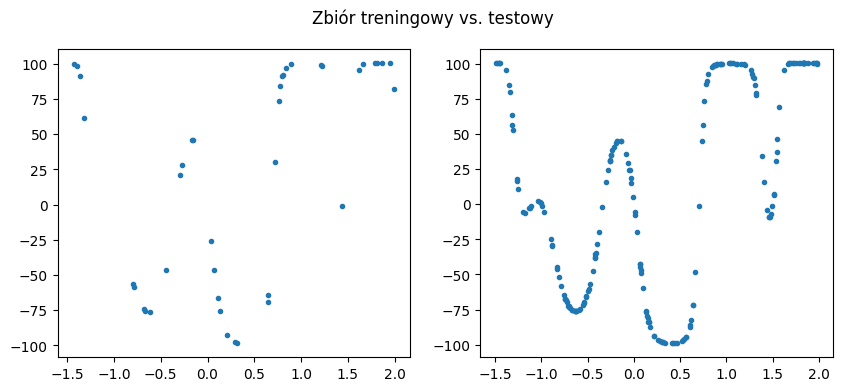

In [8]:
plot_train_test(x,y,x_test,y_test)

### Bez regularyzacji

Error in epoch 0 = 4591.008015397625
Error in epoch 50 = 1670.278240158915
Error in epoch 100 = 1407.791877581414
Error in epoch 150 = 1009.2910737837767
Error in epoch 200 = 923.1155755960968
Error in epoch 250 = 827.4680911728334
Error in epoch 300 = 726.7905949556547
Error in epoch 350 = 695.8294880306062
Error in epoch 400 = 674.2255797290497
Error in epoch 450 = 656.932617313889


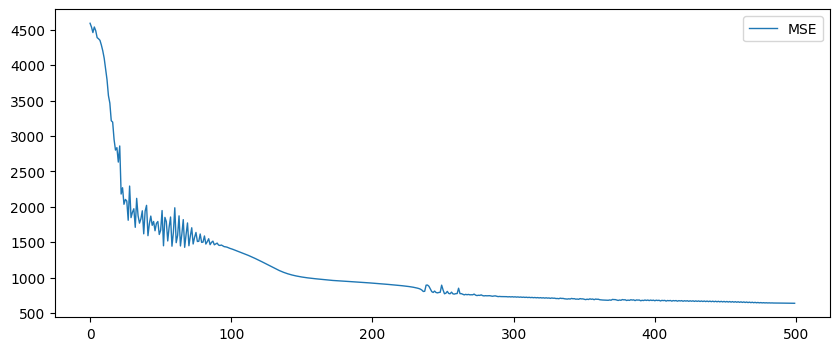

In [9]:
arch = [1, 50, 1]
epochs = 500

nn_def = NeuralNetwork(number_of_neurons = arch, activation_function_name = "sigmoid", initiate_w_b = "Uniform", use_softmax=False, visualize_weights=True)
nn_def.train(x, y, epochs=epochs, batch_size = 30, alpha=0.1, regularization_lambda=0)
y_pred = nn_def.forward(x_test)
errors_def = nn_def.errors

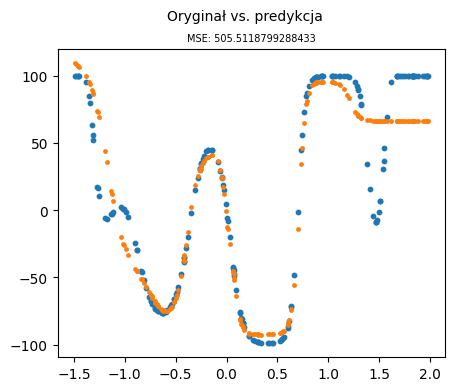

In [10]:
plot_compare_pred(x_test,y_test,y_pred,False)

### Z regularyzacją

Error in epoch 0 = 5071.313203633223
Error in epoch 50 = 1909.927589699038
Error in epoch 100 = 1165.1783700853393
Error in epoch 150 = 835.0003756230593
Error in epoch 200 = 674.4582926211314
Error in epoch 250 = 600.6284599635823
Error in epoch 300 = 567.9150347421066
Error in epoch 350 = 551.2511502121198
Error in epoch 400 = 536.3245433133117
Error in epoch 450 = 511.86577585971764


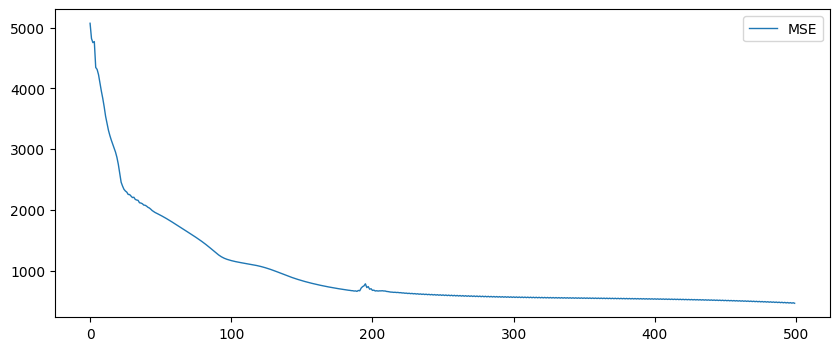

In [11]:
arch = [1, 50, 1]
epochs = 500

nn_reg = NeuralNetwork(number_of_neurons = arch, activation_function_name = "sigmoid", initiate_w_b = "Uniform", use_softmax=False, visualize_weights=True)
nn_reg.train(x, y, epochs=epochs, batch_size = 20, alpha=0.1, regularization_lambda=0.1)
y_pred = nn_reg.forward(x_test)
errors_reg = nn_reg.errors

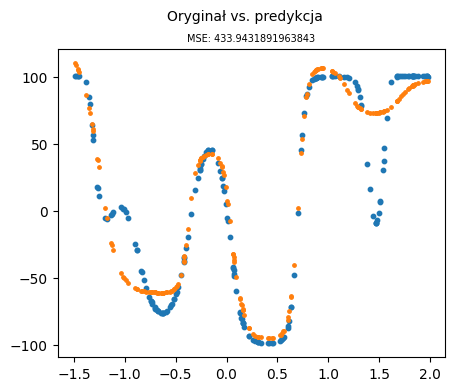

In [12]:
plot_compare_pred(x_test,y_test,y_pred,False)

### Porównanie skuteczności

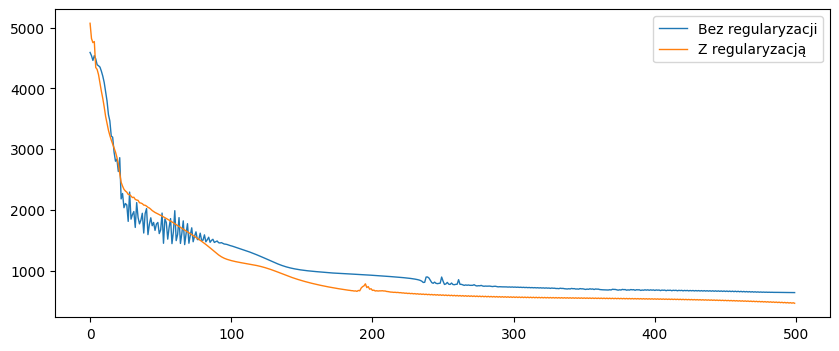

In [13]:
fig = plt.figure(figsize=(10,4))

df1 = pd.DataFrame({'x' : range(len(errors_def)), 'Bez regularyzacji' : errors_def})
df2 = pd.DataFrame({'x' : range(len(errors_reg)), 'Z regularyzacją' : errors_reg})

plt.plot('x', 'Bez regularyzacji', data=df1, linewidth=1)
plt.plot('x', 'Z regularyzacją', data=df2, linewidth=1)
plt.legend()


## Drugi zbiór danych (*rings5-sparse*)

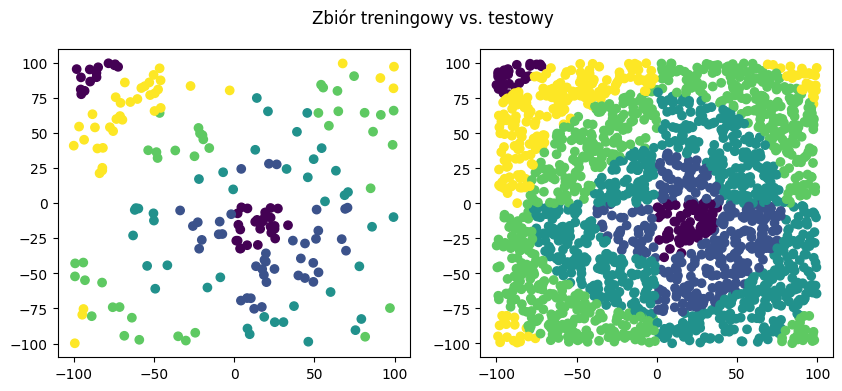

In [14]:
train_df = pd.read_csv('rings5-sparse-training.csv')
test_df = pd.read_csv('rings5-sparse-test.csv')

plot_train_test(train_df['x'], train_df['y'], test_df['x'], test_df['y'], classification=True, c=train_df['c'], c_test=test_df['c'])

In [15]:
x = np.asarray(train_df[['x', 'y']])
x_test = np.asarray(test_df[['x', 'y']])

c = np.asarray(train_df['c'])
c_test = np.asarray(test_df['c'])

encoded = np.array(one_hot(c)).T

### Bez regularyzacji

Error in epoch 0 = 9.142346463852238
Error in epoch 50 = 4.155240724958083
Error in epoch 100 = 1.865014220431751
Error in epoch 150 = 0.690427930732329
Error in epoch 200 = 0.7336605896907405
Error in epoch 250 = 0.6945707383223405
Error in epoch 300 = 0.8137202112002756
Error in epoch 350 = 1.0739324272518227
Error in epoch 400 = 0.8548161900365974
Error in epoch 450 = 0.8156641150519727


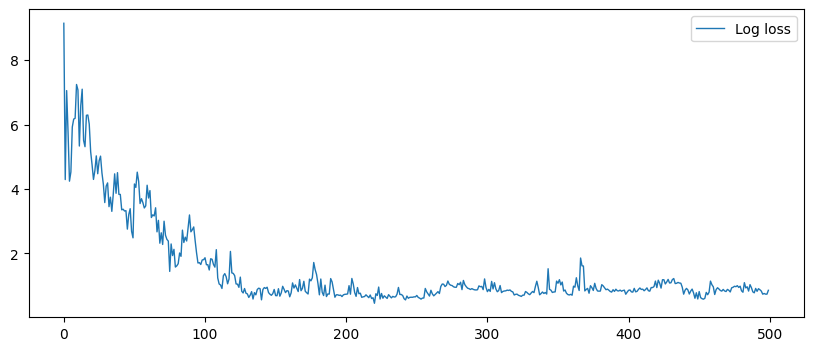

In [16]:
arch = [2, 128, 128, 128, 5]
epochs = 500

nn_def = NeuralNetwork(number_of_neurons = arch, activation_function_name = "tanh",
                       initiate_w_b = "Uniform", use_softmax=True, visualize_weights=True)
# nn_def.train(x=x, y=encoded, epochs=epochs, alpha=0.01, method="Momentum", var=0.8, regularization_lambda=0)
nn_def.train(x=x, y=encoded, epochs=epochs, batch_size=10, alpha=0.1, regularization_lambda=0)

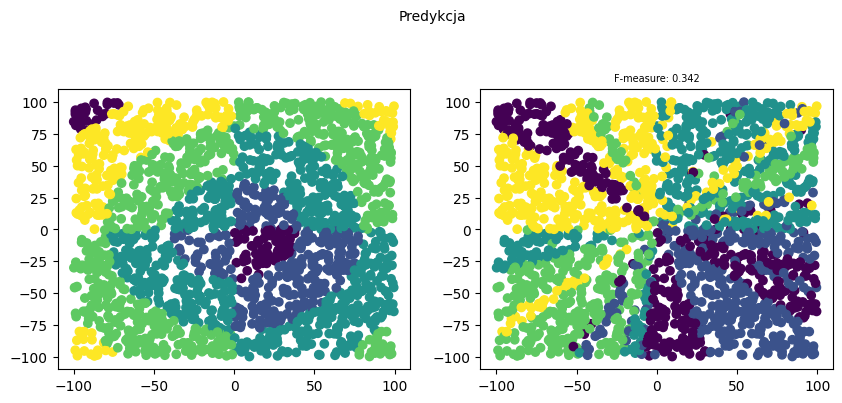

In [17]:
plot_compare_pred(test_df['x'], test_df['y'], y_pred=None, classification=True,
                  c=test_df['c'], c_pred=nn_def.classify(x_test))

### Z regularyzacją

C:\Users\laura\AppData\Local\Temp\ipykernel_4860\52907824.py:23: RuntimeWarning: overflow encountered in square
  return np.nan_to_num(1/np.cosh(x)**2)
C:\Users\laura\AppData\Local\Temp\ipykernel_4860\52907824.py:23: RuntimeWarning: overflow encountered in cosh
  return np.nan_to_num(1/np.cosh(x)**2)
C:\Users\laura\AppData\Local\Temp\ipykernel_4860\3358454476.py:108: RuntimeWarning: invalid value encountered in multiply
  D[i] = (dot(self.synaptic_weights[i + 1], D[i + 1].T) * self.activation_function_der(self.z[i]).T).T
C:\Users\laura\AppData\Local\Temp\ipykernel_4860\3358454476.py:102: RuntimeWarning: overflow encountered in square
  tmp = np.array(tmp) + regularization_lambda / (2*len(y)**2) * np.array([(weight**2).sum() for weight in self.synaptic_weights]).sum()


Error in epoch 0 = 1.6094379124341003
Error in epoch 50 = 1.6094379124341003
Error in epoch 100 = 1.6094379124341003
Error in epoch 150 = 1.6094379124341003
Error in epoch 200 = 1.6094379124341003
Error in epoch 250 = 1.6094379124341003
Error in epoch 300 = 1.6094379124341003
Error in epoch 350 = 1.6094379124341003
Error in epoch 400 = 1.6094379124341003
Error in epoch 450 = 1.6094379124341003


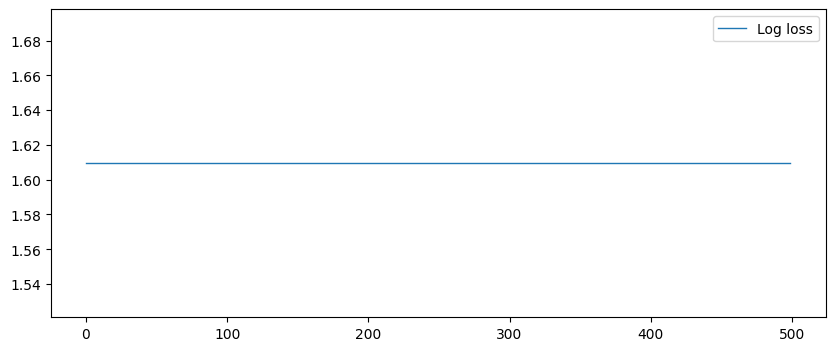

In [18]:
arch = [2, 128, 128, 128, 5]
epochs = 500

nn_reg = NeuralNetwork(number_of_neurons = arch, activation_function_name = "tanh",
                       initiate_w_b = "Uniform", use_softmax=True, visualize_weights=True)
# nn_def.train(x=x, y=encoded, epochs=epochs, alpha=0.01, method="Momentum", var=0.8, regularization_lambda=0)
nn_reg.train(x=x, y=encoded, epochs=epochs, batch_size=10, alpha=0.1, regularization_lambda=1)

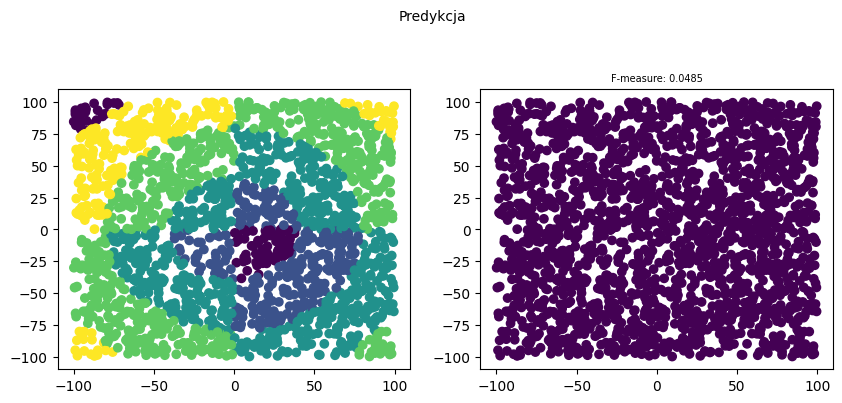

In [19]:
plot_compare_pred(test_df['x'], test_df['y'], y_pred=None, classification=True,
                  c=test_df['c'], c_pred=nn_reg.classify(x_test))

## Trzeci zbiór danych (*rings3-balance*)

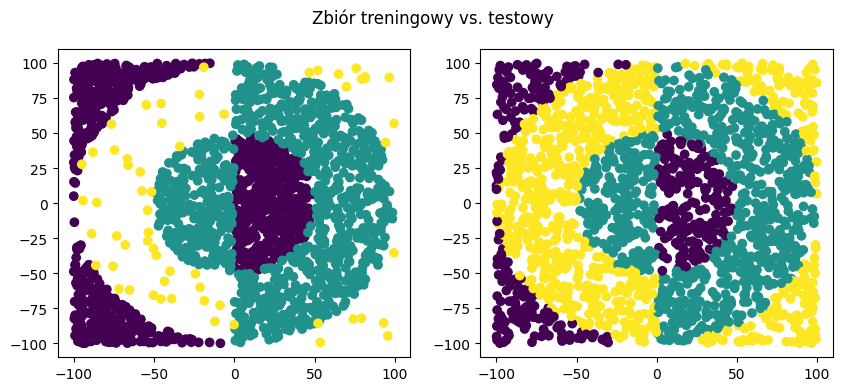

In [20]:
train_df = pd.read_csv('rings3-balance-training.csv')
test_df = pd.read_csv('rings3-balance-test.csv')

plot_train_test(train_df['x'], train_df['y'], test_df['x'], test_df['y'], classification=True, c=train_df['c'], c_test=test_df['c'])

In [21]:
x = np.asarray(train_df[['x', 'y']])
x_test = np.asarray(test_df[['x', 'y']])

c = np.asarray(train_df['c'])
c_test = np.asarray(test_df['c'])

encoded = np.array(one_hot(c)).T

Error in epoch 0 = 0.6703478111881175
Error in epoch 50 = 0.6705100950629922
Error in epoch 100 = 0.6612427173541733
Error in epoch 150 = 0.6533811180779626
Error in epoch 200 = 0.5644240146282723
Error in epoch 250 = 0.5461475411382978
Error in epoch 300 = 0.34446805167767575
Error in epoch 350 = 0.6294772120949574
Error in epoch 400 = 0.4952168237623968
Error in epoch 450 = 0.6153367050764744


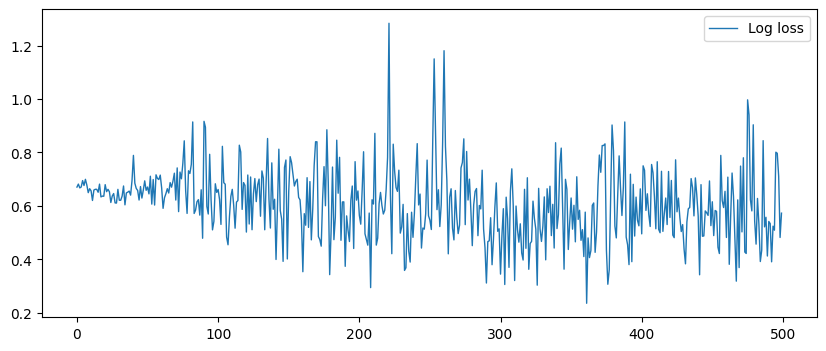

In [22]:
arch = [2, 16, 16, 3]
epochs = 500

nn_def = NeuralNetwork(number_of_neurons = arch, activation_function_name = "sigmoid",
                       initiate_w_b = "Uniform", use_softmax=True, visualize_weights=True)
nn_def.train(x=x, y=encoded, epochs=epochs, alpha=0.1, method="Momentum", var=0.8, regularization_lambda=0)

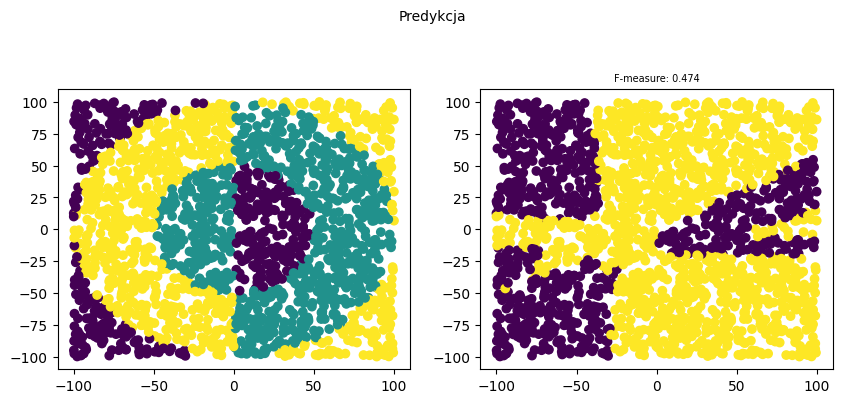

In [23]:
plot_compare_pred(test_df['x'], test_df['y'], y_pred=None, classification=True,
                  c=test_df['c'], c_pred=nn_def.classify(x_test))

Error in epoch 0 = 0.6760100783279197


C:\Users\laura\AppData\Local\Temp\ipykernel_4860\3358454476.py:102: RuntimeWarning: overflow encountered in square
  tmp = np.array(tmp) + regularization_lambda / (2*len(y)**2) * np.array([(weight**2).sum() for weight in self.synaptic_weights]).sum()
C:\Users\laura\AppData\Local\Temp\ipykernel_4860\3358454476.py:108: RuntimeWarning: invalid value encountered in multiply
  D[i] = (dot(self.synaptic_weights[i + 1], D[i + 1].T) * self.activation_function_der(self.z[i]).T).T


Error in epoch 50 = 1.09861228866811
Error in epoch 100 = 1.09861228866811
Error in epoch 150 = 1.09861228866811
Error in epoch 200 = 1.09861228866811
Error in epoch 250 = 1.09861228866811
Error in epoch 300 = 1.09861228866811
Error in epoch 350 = 1.09861228866811
Error in epoch 400 = 1.09861228866811
Error in epoch 450 = 1.09861228866811


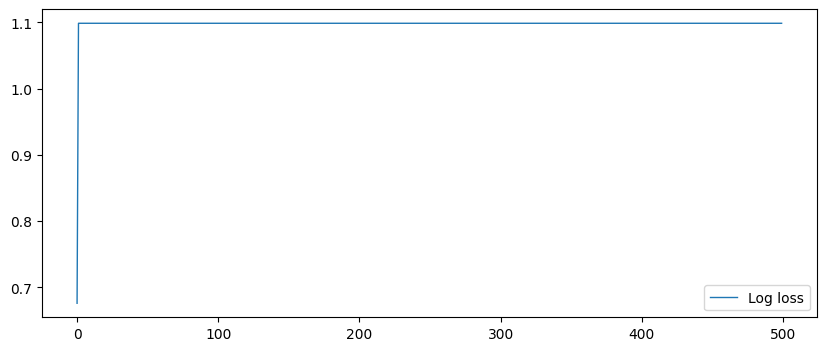

In [24]:
arch = [2, 16, 16, 3]
epochs = 500

nn_def = NeuralNetwork(number_of_neurons = arch, activation_function_name = "sigmoid",
                       initiate_w_b = "Uniform", use_softmax=True, visualize_weights=True)
nn_def.train(x=x, y=encoded, epochs=epochs, alpha=0.1, method="Momentum", var=0.8, regularization_lambda=0.5)

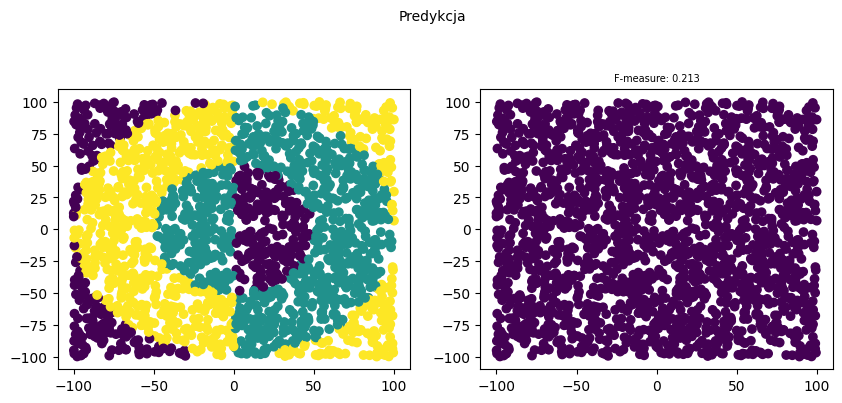

In [25]:
plot_compare_pred(test_df['x'], test_df['y'], y_pred=None, classification=True,
                  c=test_df['c'], c_pred=nn_def.classify(x_test))

## Czwarty zbiór danych (*xor3-balance*)

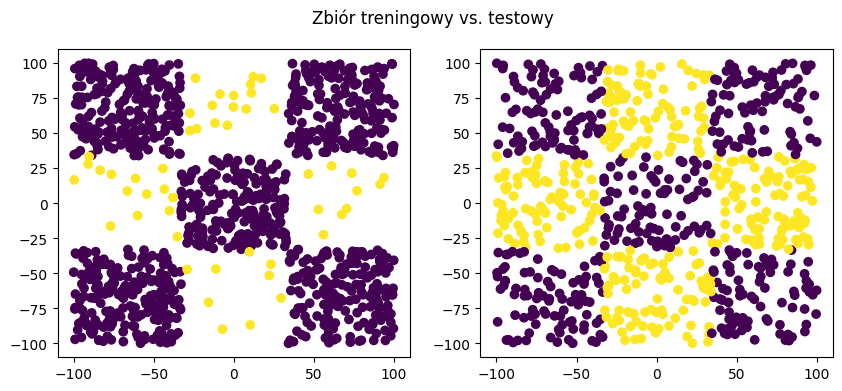

In [26]:
train_df = pd.read_csv('xor3-balance-training.csv')
test_df = pd.read_csv('xor3-balance-test.csv')

plot_train_test(train_df['x'], train_df['y'], test_df['x'], test_df['y'], classification=True, c=train_df['c'], c_test=test_df['c'])

In [27]:
x = np.asarray(train_df[['x', 'y']])
x_test = np.asarray(test_df[['x', 'y']])

c = np.asarray(train_df['c'])
c_test = np.asarray(test_df['c'])

encoded = np.array(one_hot(c)).T

Error in epoch 0 = 0.042337691045065684
Error in epoch 50 = 0.032049112967740795
Error in epoch 100 = 0.011690149558835785
Error in epoch 150 = 0.01698477408450188
Error in epoch 200 = 0.014293047980080926
Error in epoch 250 = 0.01194864384051115
Error in epoch 300 = 0.017098614722026544
Error in epoch 350 = 0.013793425775248336
Error in epoch 400 = 0.023742724038885325
Error in epoch 450 = 0.012930677363987541


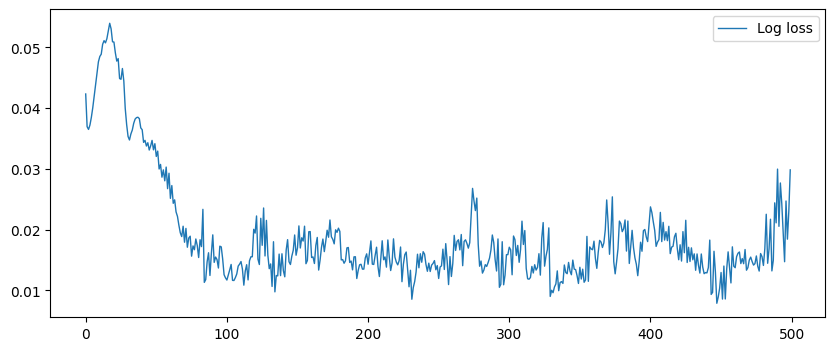

In [28]:
arch = [2, 16, 16, 2]
epochs = 500

nn_def = NeuralNetwork(number_of_neurons = arch, activation_function_name = "sigmoid",
                       initiate_w_b = "Uniform", use_softmax=True, visualize_weights=True)
nn_def.train(x=x, y=encoded, epochs=epochs, alpha=0.1, method="Momentum", var=0.8, regularization_lambda=0)

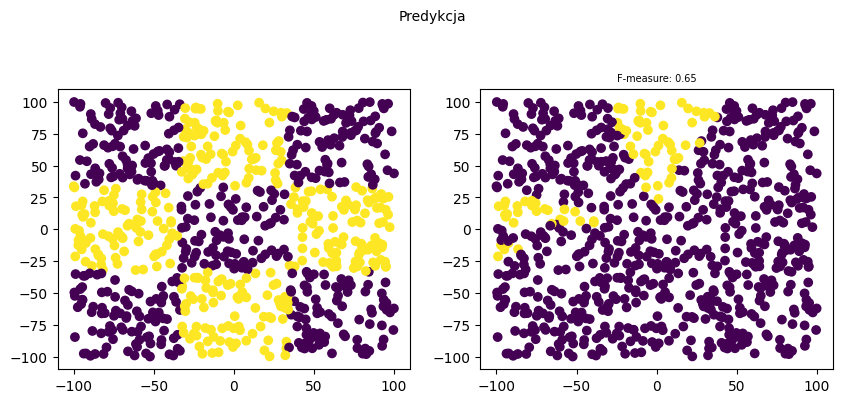

In [29]:
plot_compare_pred(test_df['x'], test_df['y'], y_pred=None, classification=True,
                  c=test_df['c'], c_pred=nn_def.classify(x_test))

Error in epoch 0 = 0.037308793123712346


C:\Users\laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\laura\AppData\Local\Temp\ipykernel_4860\3358454476.py:108: RuntimeWarning: invalid value encountered in multiply
  D[i] = (dot(self.synaptic_weights[i + 1], D[i + 1].T) * self.activation_function_der(self.z[i]).T).T


Error in epoch 50 = 0.6931471805599453
Error in epoch 100 = 0.6931471805599453
Error in epoch 150 = 0.6931471805599453
Error in epoch 200 = 0.6931471805599453
Error in epoch 250 = 0.6931471805599453
Error in epoch 300 = 0.6931471805599453
Error in epoch 350 = 0.6931471805599453
Error in epoch 400 = 0.6931471805599453
Error in epoch 450 = 0.6931471805599453


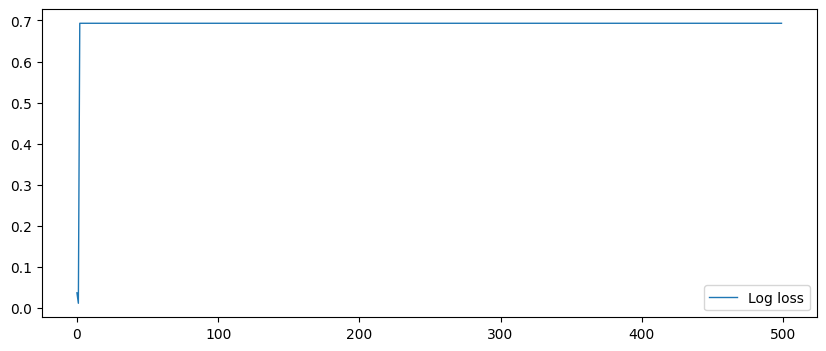

In [30]:
arch = [2, 16, 16, 2]
epochs = 500

nn_def = NeuralNetwork(number_of_neurons = arch, activation_function_name = "sigmoid",
                       initiate_w_b = "Uniform", use_softmax=True, visualize_weights=True)
nn_def.train(x=x, y=encoded, epochs=epochs, alpha=0.1, method="Momentum", var=0.8, regularization_lambda=0.5)

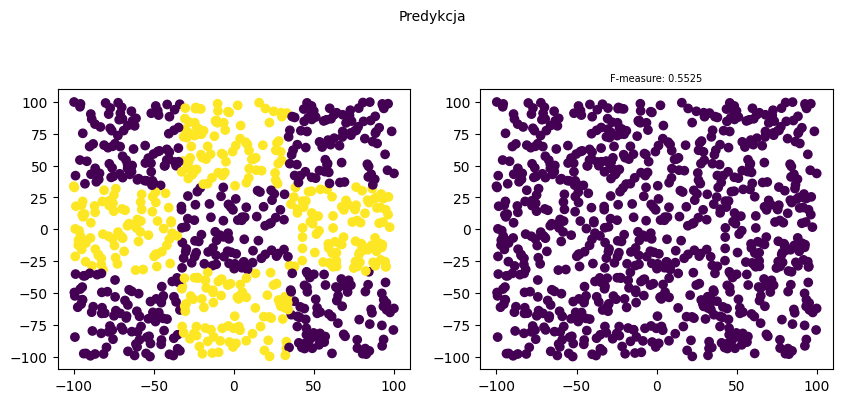

In [31]:
plot_compare_pred(test_df['x'], test_df['y'], y_pred=None, classification=True,
                  c=test_df['c'], c_pred=nn_def.classify(x_test))